Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

Submission File
For each id in the test set, you must predict a probability for the target variable. The file should contain a header and have the following format:

https://www.kaggle.com/c/tabular-playground-series-nov-2021/overview

In [1]:
!conda info


     active environment : kaggle-pgnov21
    active env location : C:\ProgramData\Anaconda3\envs\kaggle-pgnov21
            shell level : 2
       user config file : C:\Users\globetrekker\.condarc
 populated config files : C:\Users\globetrekker\.condarc
          conda version : 4.10.3
    conda-build version : 3.21.4
         python version : 3.8.8.final.0
       virtual packages : __win=0=0
                          __archspec=1=x86_64
       base environment : C:\ProgramData\Anaconda3  (writable)
      conda av data dir : C:\ProgramData\Anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<a id="0"></a>
# Table of contents 
* [Imports](#imports)
* [Useful functions](#useful-functions)
* [Plot distributions](#plot-distributions)
* [Get baseline scores](#get-baseline)
* [Optimize models](#optimize-models)
* [Drop features](#drop-features)
* [Feature importances](#feature-importances)
* [KMeans clustering](#kmeans)
* [Stacking - manual](#stacking-manual)
* [Stacking - auto](#stacking-auto)
* [Optuna](#optuna)
* [Final](#final)

<a id="0"></a>
## Imports
[Go back to top](#imports)

In [3]:
import time, gc, copy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna

pd.options.mode.chained_assignment = None  # default='warn'
%config Completer.use_jedi = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
def get_datasets(path: str, scale: bool, debug: bool):
    """Import datasets from path. Expect csvs called train.csv and test.csv

    Arguments:
    :path - path containing csvs
    :scale - run standard scaler
    :debug - run in debug mode
    
    Returns:
    :X - dataframe (train) minus target
    :y - series (target values for train)
    :df_test - dataframe (test) 
    """
    
    if debug:
        df_train = pd.read_csv(path + 'train.csv', nrows=1000)
        df_test = pd.read_csv(path + 'test.csv', nrows=1000)
    else:
        df_train = pd.read_csv(path + 'train.csv')
        df_test = pd.read_csv(path + 'test.csv')
        
    ids = df_test.id
    df_train.drop('id', axis=1, inplace=True)
    df_test.drop('id', axis=1, inplace=True)

    original_features = df_test.columns

    X = df_train[original_features]
    y = df_train['target']
    
    if scale:
        std_scaler = StandardScaler()
        X_norm = pd.DataFrame(std_scaler.fit_transform(X))
        X_norm.columns = original_features
        df_test_norm = pd.DataFrame(std_scaler.transform(df_test))
        df_test_norm.columns = original_features
    else:
        X_norm = X
        df_test_norm = df_test
    
    return X_norm, y, df_test_norm, ids

In [5]:
def get_models():
    """Return list of models for initial analysis
    
    Returns:
    :models - list of dicts(name, model)
    """
    models = [
        {'name': 'lr', 'model': LogisticRegression(random_state=5)},
        {'name': 'lsvc', 'model': LinearSVC(dual=False, random_state=5)},
        {'name': 'lgbm', 'model': LGBMClassifier(random_state=5)},
        {'name': 'bayes', 'model': GaussianNB()},
    ]
    return models

In [6]:
def evaluate_model(
    model, 
    X: pd.DataFrame, 
    y: pd.Series) -> list:
    """Return list of scores for a model

    Arguments:
    :model - model to be evaluated
    :X - dataframe (train) minus target
    :y - series (target values for train)
    
    Returns:
    scores - list of scores for model
    """
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    
    return scores

In [7]:
def evaluate_model_val_set(
    model, 
    X_train: pd.DataFrame, 
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series) -> float:
    """Return scores for a model on validation set

    Arguments:
    :model - model to be evaluated
    :X_train - training dataframe minus target
    :y_train - training series (target values for training set)
    :X_val - validation dataframe minus target
    :y_val - validation series (target values for validation set)
    
    Returns:
    score - score for model
    """
    if model.__class__.__name__ == 'LinearSVC':
        clf = CalibratedClassifierCV(base_estimator=model, cv=5)
    else:
        clf = model
    clf.fit(X_train, y_train)
    preds = clf.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, preds)
    
    return score

In [8]:
def get_feature_importances(
    X_in: pd.DataFrame, 
    y_in: pd.Series, 
    model_type: str, 
    k: int) -> pd.DataFrame:
    """Return feature importances of features as to the target prediction

    Arguments:
    :X_in - dataframe (train) minus target
    :y_in - series (target values for train)
    :model_type - 'regression' or 'classification'
    :k - number of folds 
    
    Returns:
    :featureScores - dataframe with abs correlation value sorted in asc
    """
    if model_type == 'classification':
        bestfeatures = SelectKBest(score_func=f_classif, k=k)
    else:
        bestfeatures = SelectKBest(score_func=f_regression, k=k)
    
    fit = bestfeatures.fit(X_in, y_in)

    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X_in.columns)

    # Concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score'] 
    featureScores['Abs_score'] = abs(featureScores['Score'])
    featureScores.sort_values(by='Score', axis=0, ascending=True, inplace=True)
    featureScores.reset_index(drop=True, inplace=True)
    
    return featureScores

In [9]:
def get_kmeans_labels(
    X_in: pd.DataFrame, 
    features: list,
    n_clusters: int) -> list:
    """Return kmeans labels for a dataframe

    Arguments:
    :X_in - dataframe (train) minus target
    :features - list of important features
    :n_clusters - number of kmeans clusters
    
    Returns:
    X_temp - dataframe (train) minus target plus kmeans labels
    """
    X_temp = copy.deepcopy(X_in)
    kmeans = KMeans(n_clusters=n_clusters, random_state=3)
    kmeans.fit(X_temp[features])
    X_temp['cluster'] = kmeans.predict(X_temp[features])
    
    return X_temp

In [10]:
def get_kmeans_dist_ratios(
    X_in: pd.DataFrame, 
    X_val_in: pd.DataFrame,
    X_test_in: pd.DataFrame,
    features: list,
    n_clusters: int) -> list:
    """Return kmeans labels for a dataframe

    Arguments:
    :X_in - dataframe (train) minus target
    :X_val_in - dataframe (val) minus target
    :X_test_in - dataframe (test) minus target
    :features - list of important features
    :n_clusters - number of kmeans clusters
    
    Returns:
    :X_temp - dataframe (train) minus target plus kmeans dist ratios
    :X_temp_val - dataframe (val) minus target plus kmeans dist ratios
    :X_temp_test - dataframe (test) minus target plus kmeans dist ratios
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=3)
    X_temp = copy.deepcopy(X_in)
    X_temp_val = copy.deepcopy(X_val_in)
    X_temp_test = copy.deepcopy(X_test_in)
    
    kmeans.fit(X_temp[features])
    cluster_cols = [f"cluster{i+1}" for i in range(n_clusters)]

    cluster_distances = kmeans.transform(X_temp[features])
    cluster_distances_val = kmeans.transform(X_temp_val[features])
    cluster_distances_test = kmeans.transform(X_temp_test[features])
    
    X_temp_cluster_distances = pd.DataFrame(cluster_distances, columns=cluster_cols, index=X_temp.index)
    X_temp_val_cluster_distances = pd.DataFrame(cluster_distances_val, columns=cluster_cols, index=X_temp_val.index)
    X_temp_test_cluster_distances = pd.DataFrame(cluster_distances_test, columns=cluster_cols, index=X_temp_test.index)

    new_cols = []
    for i in cluster_cols:
        for j in cluster_cols:
            if i != j:
                new_col_name = i + '_' + j
                X_temp_cluster_distances[new_col_name] = X_temp_cluster_distances[i] / X_temp_cluster_distances[j]
                X_temp_val_cluster_distances[new_col_name] = X_temp_val_cluster_distances[i] / X_temp_val_cluster_distances[j]
                X_temp_test_cluster_distances[new_col_name] = X_temp_test_cluster_distances[i] / X_temp_test_cluster_distances[j]
                new_cols.append(new_col_name)
            
    X_temp = X_temp.join(X_temp_cluster_distances[new_cols])
    X_temp_val = X_temp_val.join(X_temp_val_cluster_distances[new_cols])
    X_temp_test = X_temp_test.join(X_temp_test_cluster_distances[new_cols])
    
    return X_temp, X_temp_val, X_temp_test

In [11]:
def generate_meta_features_model(model, X_in, y_in, cv):
    """Generate meta features for single base classifier model, to be used later for stacking

    Arguments:
    :model - model to evaluate
    :X_in - dataframe with features minus target
    :y_in - target series
    :cv - cross-validation iterator 
    """
    
    # Initialize
    n_classes = len(np.unique(y_in)) # Assuming that training data contains all classes
    meta_features = np.zeros((X_in.shape[0], n_classes)) 
    n_splits = cv.get_n_splits(X_in, y_in)
    
    # Loop over folds
    print("Starting hold out prediction with {} splits for {}.".format(n_splits, model.__class__.__name__))
    for train_idx, hold_out_idx in cv.split(X_in, y_in): 
        
        # Split data
        X_in_train = X_in.iloc[train_idx]    
        y_in_train = y_in.iloc[train_idx]
        X_in_hold_out = X_in.iloc[hold_out_idx]

        # Fit estimator to K-1 parts and predict on hold out part
        est = copy.deepcopy(model)
        est.fit(X_in_train, y_in_train)
        y_in_hold_out_pred = est.predict_proba(X_in_hold_out)
        
        # Fill in meta features
        meta_features[hold_out_idx] = y_in_hold_out_pred

    return meta_features

In [12]:
def get_stack_df(models, X_input, X_input_km, y_in):
    # Loop over classifier to produce meta features
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
    meta_train = []
    meta_test = []
    for model in models:
        name = model['name']
        if name == 'lr':
            X_in = X_input
        elif name == 'lsvc':
            X_in = X_input
        else:
            X_in = X_input_km
        
        # Create hold out predictions for a classifier
        if model['model'].__class__.__name__ == 'LinearSVC':
            clf = CalibratedClassifierCV(base_estimator=model['model'], cv=5)
        else:
            clf = model['model']
        meta_train_model = generate_meta_features_model(clf, X_in, y_in, cv)

        # Remove redundant column - 0th column = 1-first column in a two class dataset 
        meta_train_model = np.delete(meta_train_model, 0, axis=1).ravel()
        print(pd.DataFrame(meta_train_model).head())

        # Gather meta training data
        meta_train.append(meta_train_model)

    meta_train = np.array(meta_train).T 
    df_meta_train = pd.DataFrame(meta_train)

    # Optional (Add original features to meta)
    df_meta_train = pd.DataFrame(np.concatenate((df_meta_train, X_in), axis=1))
    
    return df_meta_train

In [15]:
def get_stack_df_val(models, stack_model, X_input, X_input_km, y_in, X_test_input, X_test_km_input, features, ids):
    
    meta_test = []
    for model in models:
        name = model['name']
    if name == 'lr':
        X_in = X_input
        X_test_in = X_test_input
    elif name == 'lsvc':
        X_in = X_input
        X_test_in = X_test_input
    else:
        X_in = X_input_km
        X_test_in = X_test_km_input

    clf.fit(X_in, y_in)
    meta_test_model = clf.predict_proba(X_test_in)

    # Remove redundant column - 0th column = 1-first column in a two class dataset 
    meta_test_model = np.delete(meta_test_model, 0, axis=1).ravel()

    # Gather meta training data
    meta_test.append(meta_test_model)

    meta_test = np.array(meta_test).T 
    df_meta_test = pd.DataFrame(meta_test)

    # Optional (Add original features to meta)
    df_meta_test = pd.DataFrame(np.concatenate((df_meta_test, X_test_in), axis=1))
    
    return df_meta_test

In [16]:
def objective_logreg(trial, X_in, y_in, X_val_in, y_val_in):
    """Optimize logistic regression model using optuna"""
    
    solver = trial.suggest_categorical('solver', ['liblinear', 'newton-cg', 'lbfgs', 'newton-cg', 'sag', 'saga'])
    C = trial.suggest_float("C", 0.01, 2.0)
    max_iter = trial.suggest_int("max_iter", 100, 10000, step=100)
    
    penalty = 'l2'
    
    model = LogisticRegression(C=C, max_iter=max_iter, solver=solver, penalty=penalty)
    model.fit(X_in, y_in)
    preds = model.predict_proba(X_val_in)[:,1]
    score = roc_auc_score(y_val_in, preds)
    
    return score

In [17]:
def objective_linearSVC(trial, X_in, y_in, X_val_in, y_val_in):
    """Optimize linear SVC model using optuna"""
    
    C = trial.suggest_float("C", 0.01, 2.0)
    max_iter = trial.suggest_int("max_iter", 1000, 10000, step=1000)
    
    model = LinearSVC(C=C
                      , max_iter=max_iter
                      , dual=False
                      , random_state=5)
    clf = CalibratedClassifierCV(base_estimator=model, cv=5)
    clf.fit(X_in, y_in)
    
    preds = clf.predict_proba(X_val_in)[:,1]
    score = roc_auc_score(y_val_in, preds)
    
    return score

In [18]:
# get data
X, y, df_test, ids = get_datasets('../input/tabular-playground-series-nov-2021/', True, False)
original_features = list(df_test.columns)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, train_size=0.8)

# get models
models = get_models()

>lr 0.749 (0.002)
>lsvc 0.749 (0.002)
>lgbm 0.732 (0.002)
>bayes 0.636 (0.003)


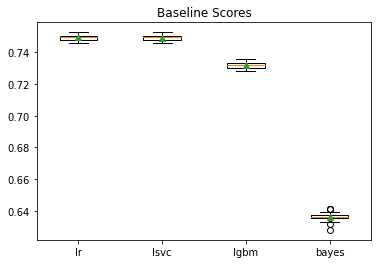

In [19]:
# evaluate baseline cross val scores of the models
results, names = list(), list()
for model in models:
    name = model['name']
    scores = evaluate_model(model['model'], X_train, y_train)
    model['init_scores'] = np.mean(scores)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.title('Baseline Scores')
plt.show()

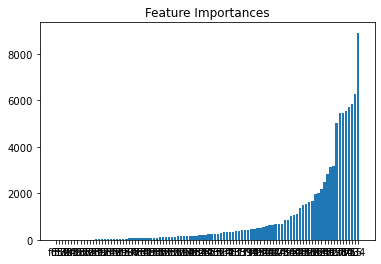

In [20]:
# get feature importances
featureScores = get_feature_importances(X_train, y_train, 'classification', 5)
plt.bar(featureScores['Specs'], featureScores['Abs_score'])
plt.title('Feature Importances')
plt.show()

>lgbm 0.737 (0.002)
>bayes 0.710 (0.002)


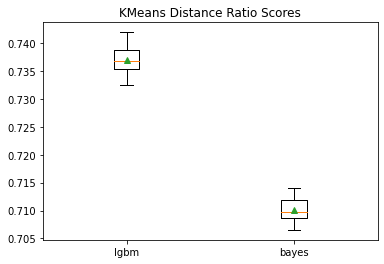

In [21]:
# evaluate cross val scores for the models by adding kmeans cluster distance ratios
results, names = list(), list()
important_features = list(featureScores.sort_values(by='Abs_score', ascending=False).head(15)['Specs'])
X_train_km, X_val_km, X_test_km = get_kmeans_dist_ratios(X_train, X_val, df_test, important_features, 10)
for model in models:
    name = model['name']
    if name == 'lr':
        pass
    elif name == 'lsvc':
        pass
    else:
        scores = evaluate_model(model['model'], X_train_km, y_train)
        model['kmeans_dist_rat_scores'] = np.mean(scores)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.title('KMeans Distance Ratio Scores')
plt.show()

In [22]:
# evaluate baseline scores of the models on validation set
for model in models:
    name = model['name']
    score = evaluate_model_val_set(model['model'], X_train, y_train, X_val, y_val)
    model['init_scores_val'] = score
    print('>%s %.3f' % (name, score))

>lr 0.748
>lsvc 0.748
>lgbm 0.731
>bayes 0.633


In [23]:
# evaluate score on val set with kmeans dist ratios added
important_features = list(featureScores.sort_values(by='Abs_score', ascending=False).head(15)['Specs'])
X_train_km, X_val_km, X_test_km = get_kmeans_dist_ratios(X_train, X_val, df_test, important_features, 10)
for model in models:
    name = model['name']
    if name == 'lr':
        pass
    elif name == 'lsvc':
        pass
    else:
        score = evaluate_model_val_set(model['model'], X_train_km, y_train, X_val_km, y_val)
        model['kmeans_dist_rat_scores_val'] = score
        print('>%s %.3f' % (name, score))

>lgbm 0.735
>bayes 0.710


Finished loading model, total used 100 iterations
Starting hold out prediction with 5 splits for LogisticRegression.
          0
0  0.229223
1  0.695775
2  0.568647
3  0.722557
4  0.645760
Starting hold out prediction with 5 splits for CalibratedClassifierCV.
          0
0  0.231152
1  0.695096
2  0.567928
3  0.722188
4  0.643830
Starting hold out prediction with 5 splits for GaussianNB.
              0
0  5.501525e-10
1  9.953064e-01
2  3.057126e-02
3  9.999980e-01
4  1.000000e+00
>['lr_', 'lsvc_', 'bayes_'] 0.746 (0.002)


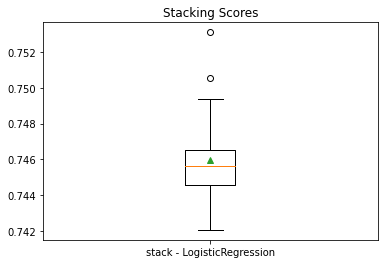

In [60]:
# evaluate scores with stacking
# get km enhanced df
important_features = list(featureScores.sort_values(by='Abs_score', ascending=False).head(15)['Specs'])
X_train_km, X_val_km, X_test_km = get_kmeans_dist_ratios(X_train, X_val, df_test, important_features, 10)
stack_model = LogisticRegression(solver='sag', C=1.6213309780417264, max_iter=1800, random_state=10)

# get meta df
models_stack = copy.deepcopy(models)
models_stack.pop(2)
df_meta_train = get_stack_df(models_stack, X_train, X_train_km, y_train)

# cross val scores from stacking
results = list()
name = [model['name'] +'_' for model in models_stack]
scores = evaluate_model(stack_model, df_meta_train, y_train)
score = np.mean(scores)
results.append(scores)
print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot stack model performance for comparison
plt.boxplot(results, labels=['stack - ' + stack_model.__class__.__name__], showmeans=True)
plt.title('Stacking Scores')
plt.show()

Finished loading model, total used 100 iterations
Starting hold out prediction with 5 splits for LogisticRegression.
          0
0  0.229223
1  0.695775
2  0.568647
3  0.722557
4  0.645760
Starting hold out prediction with 5 splits for CalibratedClassifierCV.
          0
0  0.231152
1  0.695096
2  0.567928
3  0.722188
4  0.643830
Starting hold out prediction with 5 splits for LGBMClassifier.
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
          0
0  0.260928
1  0.698825
2  0.456899
3  0.741388
4  0.609898
>['lr_', 'lsvc_', 'lgbm_'] 0.747 (0.002)


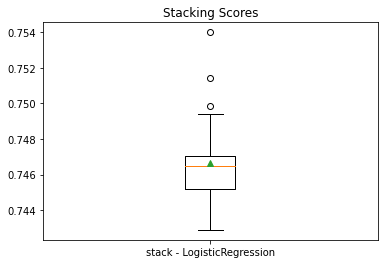

In [61]:
stack_model = LogisticRegression(solver='sag', C=1.6213309780417264, max_iter=1800, random_state=10)

# get meta df
models_stack = copy.deepcopy(models)
models_stack.pop(3)
df_meta_train = get_stack_df(models_stack, X_train, X_train_km, y_train)

# cross val scores from stacking
results = list()
name = [model['name'] +'_' for model in models_stack]
scores = evaluate_model(stack_model, df_meta_train, y_train)
score = np.mean(scores)
results.append(scores)
print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot stack model performance for comparison
plt.boxplot(results, labels=['stack - ' + stack_model.__class__.__name__], showmeans=True)
plt.title('Stacking Scores')
plt.show()

Finished loading model, total used 100 iterations
Starting hold out prediction with 5 splits for LogisticRegression.
          0
0  0.229223
1  0.695775
2  0.568647
3  0.722557
4  0.645760
Starting hold out prediction with 5 splits for LGBMClassifier.
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
          0
0  0.260928
1  0.698825
2  0.456899
3  0.741388
4  0.609898
Starting hold out prediction with 5 splits for GaussianNB.
              0
0  5.501525e-10
1  9.953064e-01
2  3.057126e-02
3  9.999980e-01
4  1.000000e+00
>['lr_', 'lgbm_', 'bayes_'] 0.746 (0.002)


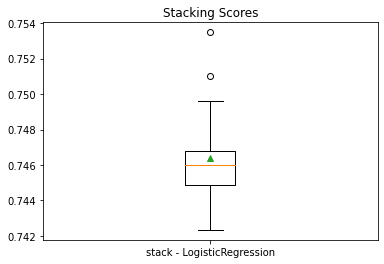

In [62]:
stack_model = LogisticRegression(solver='sag', C=1.6213309780417264, max_iter=1800, random_state=10)

# get meta df
models_stack = copy.deepcopy(models)
models_stack.pop(1)
df_meta_train = get_stack_df(models_stack, X_train, X_train_km, y_train)

# cross val scores from stacking
results = list()
name = [model['name'] +'_' for model in models_stack]
scores = evaluate_model(stack_model, df_meta_train, y_train)
score = np.mean(scores)
results.append(scores)
print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot stack model performance for comparison
plt.boxplot(results, labels=['stack - ' + stack_model.__class__.__name__], showmeans=True)
plt.title('Stacking Scores')
plt.show()

Finished loading model, total used 100 iterations
Starting hold out prediction with 5 splits for CalibratedClassifierCV.
          0
0  0.231152
1  0.695096
2  0.567928
3  0.722188
4  0.643830
Starting hold out prediction with 5 splits for LGBMClassifier.
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
          0
0  0.260928
1  0.698825
2  0.456899
3  0.741388
4  0.609898
Starting hold out prediction with 5 splits for GaussianNB.
              0
0  5.501525e-10
1  9.953064e-01
2  3.057126e-02
3  9.999980e-01
4  1.000000e+00
>['lsvc_', 'lgbm_', 'bayes_'] 0.746 (0.002)


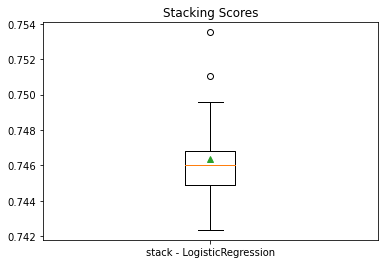

In [63]:
stack_model = LogisticRegression(solver='sag', C=1.6213309780417264, max_iter=1800, random_state=10)

# get meta df
models_stack = copy.deepcopy(models)
models_stack.pop(0)
df_meta_train = get_stack_df(models_stack, X_train, X_train_km, y_train)

# cross val scores from stacking
results = list()
name = [model['name'] +'_' for model in models_stack]
scores = evaluate_model(stack_model, df_meta_train, y_train)
score = np.mean(scores)
results.append(scores)
print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot stack model performance for comparison
plt.boxplot(results, labels=['stack - ' + stack_model.__class__.__name__], showmeans=True)
plt.title('Stacking Scores')
plt.show()

In [69]:
# optimize logistic regression
study = optuna.create_study(direction='maximize', study_name="Logistic regression")
func = lambda trial: objective_logreg(trial, X_train, y_train,  X_val, y_val)
study.optimize(func, n_trials=40)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_value)

[I 2021-11-28 17:50:54,746] A new study created in memory with name: Logistic regression
C:\ProgramData\Anaconda3\envs\kaggle-pgnov21\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\ProgramData\Anaconda3\envs\kaggle-pgnov21\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\envs\kaggle-pgnov21\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
[I 2021-11-28 17:51:01,172] Trial 0 finished with value: 0.7509228749607932 and parameters: {'solver': 'newton-cg', 'C': 1.813027073372824, 'max_iter': 2100}. Best is trial 0 with value: 0.7509228749607932.
C:\ProgramData\Anaconda3\envs\kaggle-pgnov21\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearc

[I 2021-11-28 17:54:01,459] Trial 23 finished with value: 0.7509228471754814 and parameters: {'solver': 'saga', 'C': 0.19998684312060375, 'max_iter': 100}. Best is trial 12 with value: 0.7509230074967306.
C:\ProgramData\Anaconda3\envs\kaggle-pgnov21\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\ProgramData\Anaconda3\envs\kaggle-pgnov21\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\ProgramData\Anaconda3\envs\kaggle-pgnov21\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
[I 2021-11-28 17:54:07,065] Trial 24 finished with value: 0.7509228741272339 and parameters: {'solver': 'newton-cg', 'C': 0.510662456428667, 'max_iter': 1500}. Best is trial 12 with value: 0.750923

Number of finished trials: 40
Best trial: {'solver': 'newton-cg', 'C': 0.023672809391721117, 'max_iter': 200}
Best score: 0.7509230074967306


In [ ]:
clf = LogisticRegression(solver='newton-cg', C=0.023672809391721117, max_iter=200)
clf.fit(X, y)
preds = clf.predict_proba(df_test)[:,1]

output = pd.DataFrame({'id': ids, 'target': preds})
output.to_csv('submission.csv', index=False)

In [79]:
study = optuna.create_study(direction='maximize', study_name="LinearSVC")
func = lambda trial: objective_linearSVC(trial, X_train, y_train,  X_val, y_val)
study.optimize(func, n_trials=40)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_value)

[I 2021-11-28 18:21:40,476] A new study created in memory with name: LinearSVC
[I 2021-11-28 18:21:51,970] Trial 0 finished with value: 0.7497149200256543 and parameters: {'C': 0.6965933474301265, 'max_iter': 9000}. Best is trial 0 with value: 0.7497149200256543.
[I 2021-11-28 18:22:03,594] Trial 1 finished with value: 0.7497149208590719 and parameters: {'C': 1.547469698675367, 'max_iter': 6000}. Best is trial 1 with value: 0.7497149208590719.
[I 2021-11-28 18:22:16,235] Trial 2 finished with value: 0.7497149194700427 and parameters: {'C': 0.8836134159726222, 'max_iter': 1000}. Best is trial 1 with value: 0.7497149208590719.
[I 2021-11-28 18:22:32,521] Trial 3 finished with value: 0.7497149169697902 and parameters: {'C': 0.3900984305648511, 'max_iter': 9000}. Best is trial 1 with value: 0.7497149208590719.
[I 2021-11-28 18:22:48,255] Trial 4 finished with value: 0.7497149194700425 and parameters: {'C': 1.8374541010699128, 'max_iter': 9000}. Best is trial 1 with value: 0.749714920859071

Number of finished trials: 40
Best trial: {'C': 0.012249147757314706, 'max_iter': 6000}
Best score: 0.7497149600296948


In [110]:
model = LinearSVC(dual=False, C=0.012249147757314706, max_iter=10000)
clf = CalibratedClassifierCV(base_estimator=model, cv=5)
scores = evaluate_model(model, X, y)
print(scores.mean())

0.7490073647154942


In [25]:
improvement = [
                {'col': 'f93', 'score': 0.74937980496359},
                {'col': 'f51', 'score': 0.74929966989194},
                {'col': 'f87', 'score': 0.749286577319145},
                {'col': 'f68', 'score': 0.749277139834924},
                {'col': 'f78', 'score': 0.749276882213393},
                {'col': 'f62', 'score': 0.749275147148718},
                {'col': 'f89', 'score': 0.749274390959197},
                {'col': 'f52', 'score': 0.749274337874286},
                {'col': 'f56', 'score': 0.749272925899996},
                {'col': 'f99', 'score': 0.749269564354892},
                {'col': 'f94', 'score': 0.749269362702158},
                {'col': 'f61', 'score': 0.749268842818711},
                {'col': 'f69', 'score': 0.74926548927119},
                {'col': 'f88', 'score': 0.749265103672684},
                {'col': 'f58', 'score': 0.749264578471603},
                {'col': 'f71', 'score': 0.749263915691012},
                {'col': 'f92', 'score': 0.749263337182983},
                {'col': 'f83', 'score': 0.749263137845553},
                {'col': 'f73', 'score': 0.749262998472393},
                {'col': 'f79', 'score': 0.749262939316809},
                {'col': 'f53', 'score': 0.749262568712333},
                {'col': 'f85', 'score': 0.749262562170475},
                {'col': 'f74', 'score': 0.749262225483844},
                {'col': 'f77', 'score': 0.749261144172846},
                {'col': 'f97', 'score': 0.749260238700895},
                {'col': 'f59', 'score': 0.749260187189176},
                {'col': 'f70', 'score': 0.749260078084847},
                {'col': 'f60', 'score': 0.749259985882995},
                {'col': 'f72', 'score': 0.749259923139526},
                {'col': 'f63', 'score': 0.749259705338838},
                {'col': 'f84', 'score': 0.749259697064632},
                {'col': 'f66', 'score': 0.749259548369621},
                {'col': 'f91', 'score': 0.749259409284883},
                {'col': 'f65', 'score': 0.749259081163499},
                {'col': 'f48', 'score': 0.749258667148775},
                {'col': 'f49', 'score': 0.749258585306697},
                {'col': 'f47', 'score': 0.749258369703664},
                {'col': 'f90', 'score': 0.749258194850275},
                {'col': 'f54', 'score': 0.749257967613653},
                {'col': 'f76', 'score': 0.749257919343268},
                {'col': 'f80', 'score': 0.74925790348247},
                {'col': 'f86', 'score': 0.749257678676559},
                {'col': 'f64', 'score': 0.74925764556949},
                {'col': 'f81', 'score': 0.749257545496114},
                {'col': 'f67', 'score': 0.749257539881676},
                {'col': 'f55', 'score': 0.749257196943374},
                {'col': 'f50', 'score': 0.749256959290237},
                {'col': 'f98', 'score': 0.749256646449602},
                {'col': 'f95', 'score': 0.749256167263361},
                {'col': 'f82', 'score': 0.749255080858109},
                {'col': 'f75', 'score': 0.749254809977639},
                {'col': 'f96', 'score': 0.749254111891067},
                {'col': 'f57', 'score': 0.749253100324584},
                {'col': 'f20', 'score': 0.749065261635948},
                {'col': 'f9', 'score': 0.749024452041971},
                {'col': 'f16', 'score': 0.749022277167482},
                {'col': 'f44', 'score': 0.749019719653472},
                {'col': 'f24', 'score': 0.749017390532322},
              ]


In [26]:
# baseline_score = 0.7490073647154942
# improved_cols = []
# for col in X.columns:
#         print(col)
#         model = LinearSVC(dual=False, C=0.012249147757314706, max_iter=10000)
#         clf = CalibratedClassifierCV(base_estimator=model, cv=5)

#         X_new = copy.deepcopy(X_train)
#         new_col = col + '_bin'
#         X_new[new_col], bins = pd.qcut(X_train[col], q=1000, retbins=True, labels=False)

#         scores = evaluate_model(model, X_new, y_train)
#         new_score = scores.mean()
#         if new_score >= baseline_score + 0.00001:
#             new_col = {'col': col, 'score': new_score}
#             improved_cols.append(new_col)
# print(improved_cols)

In [ ]:
# df_test_new = copy.deepcopy(df_test)
# X_new.drop(['f1'], axis=1, inplace=True)
# df_test_new['f2_bin'] = pd.cut(df_test_new['f2'], bins=bins, labels=False, include_lowest=True)

In [42]:
model = LinearSVC(dual=False, C=0.012249147757314706, max_iter=10000)
clf = CalibratedClassifierCV(base_estimator=model, cv=5)


X_new = copy.deepcopy(X_train)
df_test_new = copy.deepcopy(df_test)

col = 'f51'
new_col = col + '_bin'
X_new[new_col], bins = pd.qcut(X_new[col], q=1000, retbins=True, labels=False)
df_test_new[new_col] = pd.cut(df_test_new[col], bins=bins, labels=False, include_lowest=True)
df_test_new[new_col].fillna(df_test_new[new_col].mode()[0], inplace=True)

col = 'f52'
new_col = col + '_bin'
X_new[new_col], bins = pd.qcut(X_new[col], q=1000, retbins=True, labels=False)
df_test_new[new_col] = pd.cut(df_test_new[col], bins=bins, labels=False, include_lowest=True)
df_test_new[new_col].fillna(df_test_new[new_col].mode()[0], inplace=True)

clf.fit(X_new, y_train)

preds = clf.predict_proba(df_test_new)[:,1]

output = pd.DataFrame({'id': ids, 'target': preds})
output.to_csv('submission.csv', index=False)

In [ ]:
def make_prediction_stack(models_in, stack_model_in, X_in, y_in, features, df_test_in, ids_in):
    """Generate predictions for a single model"""
    
    X_in = X_in[features]
    df_test_in = df_test_in[features]
    
    meta_test_in = []
    for model in models_in:
        # Fit model

        # Create hold out predictions for a classifier
        if model.__class__.__name__ == 'LinearSVC':
            clf = CalibratedClassifierCV(base_estimator=model, cv=n_splits)
        else:
            clf = model
        
        clf.fit(X_in, y_in)
        meta_test_model = clf.predict_proba(df_test_in)
    
        # Remove redundant column - 0th column = 1-first column in a two class dataset 
        meta_test_model = np.delete(meta_test_model, 0, axis=1).ravel()
    
        # Gather meta training data
        meta_test_in.append(meta_test_model)
    
        meta_test_in = np.array(meta_test_in).T 
        df_meta_test_in = pd.DataFrame(meta_test_in)

    # Optional (Add original features to meta)
    df_meta_test_in = pd.DataFrame(np.concatenate((df_meta_test_in, df_test_in), axis=1))
    
    stack_model_in.fit(pd.DataFrame(df_meta_train), y_train_norm)

    # Final output
    preds = stack_model.predict_proba(df_meta_test)[:,1]
    output = pd.DataFrame({'id': ids, 'target': preds})
    output.to_csv('submission.csv', index=False)
    
    preds = clf.predict_proba(df_test_in)[:,1]
    df_preds = pd.DataFrame({'id': ids_in, 'target': preds})
    return df_preds

<a id="optimize-models"></a>
## Optimize models
[Go back to top](#0)

In [248]:
def objective_lightgbm(trial):
    """Optimize logistic regression model using optuna"""
    
    num_leaves = trial.suggest_int("num_leaves", 11, 101, step=10)
    max_depth = trial.suggest_int("max_depth", 2, 10, step=1)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 2.0)
    
    model = LGBMClassifier(num_leaves=num_leaves
                           , max_depth=max_depth
                           , learning_rate=learning_rate
                           , objective='binary'
                           , random_state=5)
    model.fit(X_train_norm, y_train_norm)
    preds = model.predict_proba(X_val_norm)[:,1]
    score = roc_auc_score(y_val_norm, preds)
    
    return score

In [249]:
%%time 

study = optuna.create_study(direction='maximize', study_name="LightGBM")
func = lambda trial: objective_lightgbm(trial)
study.optimize(func, n_trials=40)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_value)

[I 2021-11-15 22:45:21,858] A new study created in memory with name: LightGBM
[I 2021-11-15 22:45:33,351] Trial 0 finished with value: 0.729726569958354 and parameters: {'num_leaves': 81, 'max_depth': 5, 'learning_rate': 0.4139371668653664}. Best is trial 0 with value: 0.729726569958354.
[I 2021-11-15 22:45:50,222] Trial 1 finished with value: 0.7350786127919944 and parameters: {'num_leaves': 31, 'max_depth': 9, 'learning_rate': 0.23455617314768773}. Best is trial 1 with value: 0.7350786127919944.
[I 2021-11-15 22:45:58,082] Trial 2 finished with value: 0.7241467739241488 and parameters: {'num_leaves': 101, 'max_depth': 2, 'learning_rate': 1.145256335798105}. Best is trial 1 with value: 0.7350786127919944.
[I 2021-11-15 22:46:05,701] Trial 3 finished with value: 0.7307384510239672 and parameters: {'num_leaves': 61, 'max_depth': 2, 'learning_rate': 0.5457435485692936}. Best is trial 1 with value: 0.7350786127919944.
[I 2021-11-15 22:46:20,366] Trial 4 finished with value: 0.651507903528

[I 2021-11-15 22:54:41,697] Trial 36 finished with value: 0.733680391801035 and parameters: {'num_leaves': 41, 'max_depth': 10, 'learning_rate': 0.13298928601825408}. Best is trial 32 with value: 0.735608734921519.
[I 2021-11-15 22:55:00,029] Trial 37 finished with value: 0.7268634823529679 and parameters: {'num_leaves': 61, 'max_depth': 10, 'learning_rate': 0.3423141619908766}. Best is trial 32 with value: 0.735608734921519.
[I 2021-11-15 22:55:20,553] Trial 38 finished with value: 0.6994875015285098 and parameters: {'num_leaves': 31, 'max_depth': 9, 'learning_rate': 0.026611370494423248}. Best is trial 32 with value: 0.735608734921519.
[I 2021-11-15 22:55:37,097] Trial 39 finished with value: 0.7256643000711207 and parameters: {'num_leaves': 21, 'max_depth': 10, 'learning_rate': 0.5245903234797886}. Best is trial 32 with value: 0.735608734921519.


Number of finished trials: 40
Best trial: {'num_leaves': 41, 'max_depth': 10, 'learning_rate': 0.16009554199052495}
Best score: 0.735608734921519
Wall time: 10min 15s


In [250]:
df_new = pd.DataFrame([['LGBMClassifier', study.best_trial.params]])
df_new.columns = ['model', 'params']
df_model_params_optimized = pd.concat([df_model_params_optimized, df_new], axis=0)
df_model_params_optimized

,model,params
0,RandomForestClassifier,"{'n_estimators': 200, 'max_features': 'log2', ..."
0,LogisticRegression,"{'solver': 'sag', 'C': 1.6213309780417264, 'ma..."
0,LGBMClassifier,"{'num_leaves': 41, 'max_depth': 10, 'learning_..."


<a id="stacking-manual"></a>
## Stacking - Manual
[Go back to top](#0)

In [340]:
# Create hold out predictions (meta-features)
def generate_meta_features(model, X_in, y_in, cv):
    """Generate meta features for base classifier model, to be used later for stacking

    Keyword arguments:
    model -- model to evaluate
    X_in -- dataframe with features minus target
    y_in -- target series
    cv -- cross-validation iterator 
    """
    
    """Performing cross validation hold out predictions for stacking"""
    # Initilize
    n_classes = len(np.unique(y_in)) # Assuming that training data contains all classes
    meta_features = np.zeros((X_in.shape[0], n_classes)) 
    n_splits = cv.get_n_splits(X_in, y_in)
    
    # Loop over folds
    print("Starting hold out prediction with {} splits for {}.".format(n_splits, model.__class__.__name__))
    for train_idx, hold_out_idx in cv.split(X_in, y_in): 
        
        # Split data
        X_in_train = X_in.iloc[train_idx]    
        y_in_train = y_in.iloc[train_idx]
        X_in_hold_out = X_in.iloc[hold_out_idx]

        # Fit estimator to K-1 parts and predict on hold out part
        est = copy.deepcopy(model)
        est.fit(X_in_train, y_in_train)
        y_in_hold_out_pred = est.predict_proba(X_in_hold_out)
        
        # Fill in meta features
        meta_features[hold_out_idx] = y_in_hold_out_pred

    return meta_features

In [343]:
%%time

# # Predict on stacking classifier

# # Set seed
# if 'random_state' in stack_model.get_params().keys():
#     stack_model.set_params(random_state=5)


# scores = cross_val_score(estimator=stack_model, X=df_meta_train, y=y_train_norm, cv=n_splits, scoring='roc_auc')
# score = scores.mean()
# print('%.2f' % (score*100))

Wall time: 0 ns


<a id="final"></a>
## Final submission
[Go back to top](#0)

In [353]:
model = LinearSVC(C=0.18747740329972518, max_iter=9000, dual=False, random_state=5)
output = make_prediction_model(model, X_train_norm, y_train_norm, original_features, df_test_norm, ids)
output.to_csv('submission.csv', index=False)

In [344]:
%%time

X_train_norm = X_train_norm[original_features]
meta_test = []
for model in base_models:
    # Fit model
    
    # Create hold out predictions for a classifier
    if model.__class__.__name__ == 'LinearSVC':
        clf = CalibratedClassifierCV(base_estimator=model, cv=n_splits)
    else:
        clf = model
        
    clf.fit(X_train_norm, y_train_norm)
    meta_test_model = clf.predict_proba(df_test_norm)
    
    # Remove redundant column - 0th column = 1-first column in a two class dataset 
    meta_test_model = np.delete(meta_test_model, 0, axis=1).ravel()
    
    # Gather meta training data
    meta_test.append(meta_test_model)
    
meta_test = np.array(meta_test).T 
df_meta_test = pd.DataFrame(meta_test)

# Optional (Add original features to meta)
df_meta_test = pd.DataFrame(np.concatenate((df_meta_test, df_test_norm), axis=1))

Wall time: 34.5 s


In [346]:
stack_model.fit(pd.DataFrame(df_meta_train), y_train_norm)

# Final output
preds = stack_model.predict_proba(df_meta_test)[:,1]
output = pd.DataFrame({'id': ids, 'target': preds})
output.to_csv('submission.csv', index=False)